## Required Libraries

Start by loading the required libraries in Python. 

In [1]:
import torch
from torch import nn
from IPython import display
from PIL import Image
from torch.autograd import Variable
from torchvision import models, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
import scipy.io as sio
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Code taken from https://www.cs.ubc.ca/~lsigal/teaching18.html

# Define a global transformer to appropriately scale images and subsequently convert them to a Tensor.
img_size = 572
loader = transforms.Compose([
  transforms.Resize(img_size),
  transforms.CenterCrop(img_size),
  transforms.ToTensor(),
]) 
def load_image(filename, isRGB=0):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    if(isRGB):
        image = Image.open(filename).convert('RGB')
    else:
        image = Image.open(filename)
        
    image_tensor = loader(image).float()
    image_var = Variable(image_tensor).unsqueeze(0)
    return image_var.cuda()

## UNet Model

Then we can begin to implement the UNet model. Please note that the original authors of the model made the code readily avaialable based on Cafe (Ronneberger et al., 2015) which has allowed many different iterations to be easily found. In this project, I used the pytorch implementation of the model found at (https://github.com/jvanvugt/pytorch-unet) which is written in a modular way so adding new functionalitie is possible.

In [3]:
# Code taken from https://github.com/jvanvugt/pytorch-unet

class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False,
                 batch_norm=False, up_mode='upconv'):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(UNetConvBlock(prev_channels, 2**(wf+i),
                                                padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2**(wf+i), up_mode,
                                            padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path)-1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i-1])

        return self.last(x)



In [4]:
# Code taken from https://github.com/jvanvugt/pytorch-unet

class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


In [5]:
# Code taken from https://github.com/jvanvugt/pytorch-unet

class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

## No training Output

Below is sample image from the dataset for which we would like to extract white matter tracts.

![image](Untitled.jpg)


In [6]:
num_train = 24
img_size = 572

training_vectors = torch.zeros((num_train,img_size,img_size)).cuda()
train_dir = "train_data_preprocessed/"

for i in tqdm(range(num_train)):
    img_addr = train_dir + "img"+ str(i)+".tif"    
    training_vectors[i] = load_image(img_addr)
    
torch.save(training_vectors,'outputs/training_vectors')
#these can now be loaded from file for later parts

In [7]:
num_train = 24
img_size = 572

training_vectors_rgb = torch.zeros((num_train,3,img_size,img_size)).cuda()
train_dir = "train_data_preprocessed/"

for i in tqdm(range(num_train)):
    img_addr = train_dir + "img_rgb"+ str(i)+".tif"
    img = load_image(img_addr,True)
    training_vectors_rgb[i] = load_image(img_addr,True)
    
torch.save(training_vectors_rgb,'outputs/training_vectors_rgb')
#these can now be loaded from file for later parts

/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


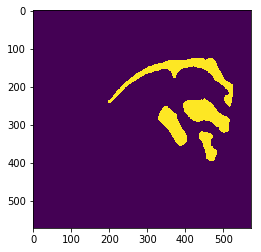

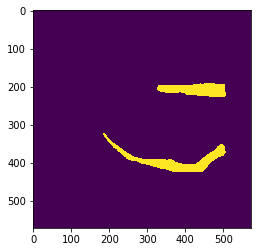

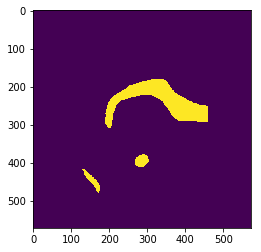

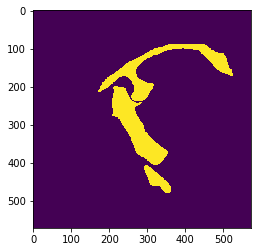

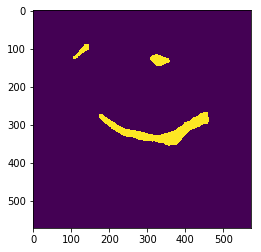

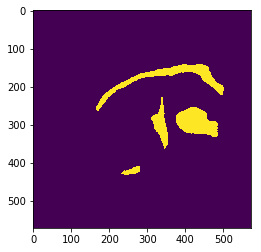

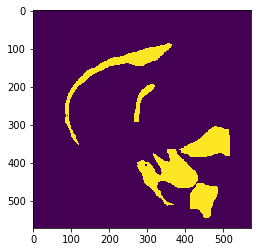

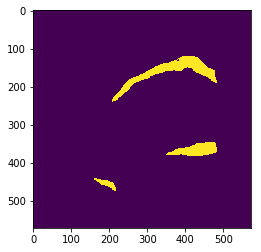

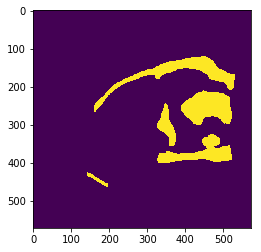

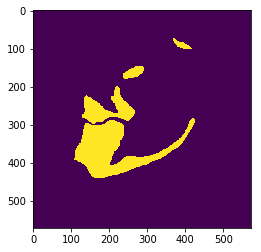

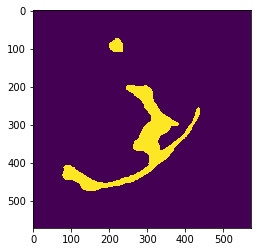

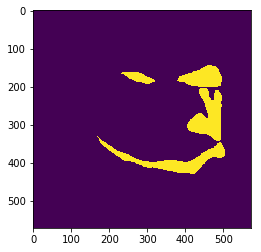

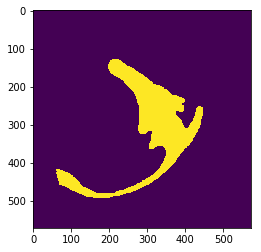

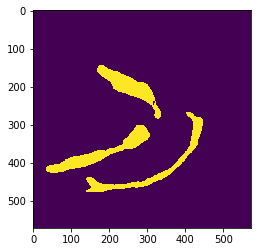

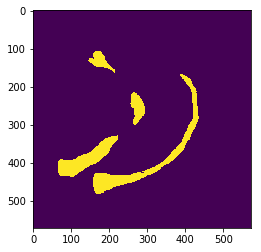

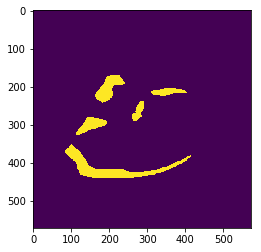

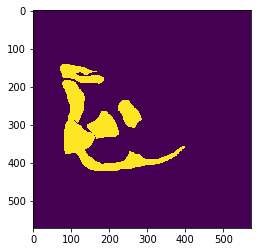

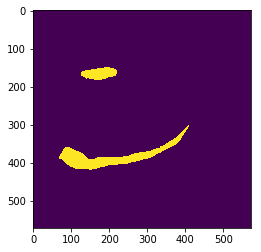

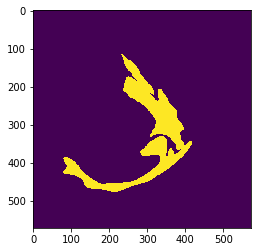

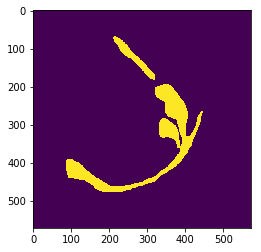

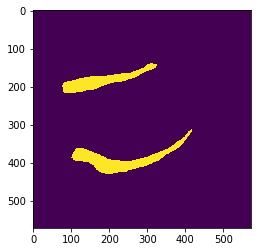

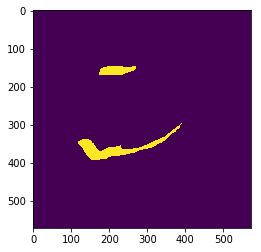

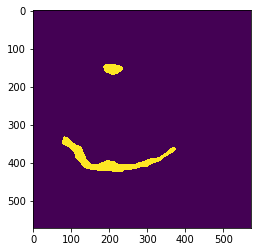

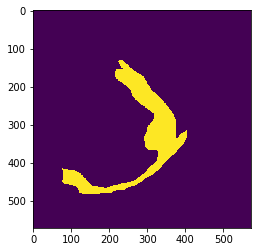

In [8]:
num_train = 24
img_size = 572

tr_lbls_2c = torch.zeros((num_train,img_size,img_size), dtype = torch.long).cuda()
train_dir = "train_data_preprocessed/"

for i in tqdm(range(num_train)):
    label_addr = train_dir + "label"+ str(i)+".mat"    
    mat_contents = sio.loadmat(label_addr)
    label =mat_contents['label']
    
    ind = np.where(label==2)
    new_label = np.zeros_like(label)
    new_label[ind] = 1
    
    tr_lbls_2c[i] = torch.from_numpy(new_label.astype(int))
    plt.figure(i)
    plt.imshow(tr_lbls_2c[i].cpu())

torch.save(tr_lbls_2c,'outputs/training_labels_2class')
#these can now be loaded from file for later parts


/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


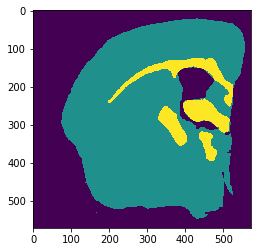

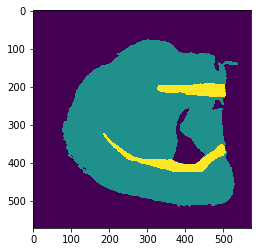

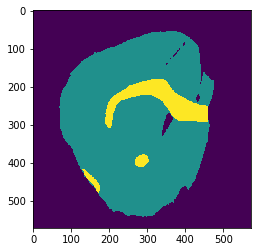

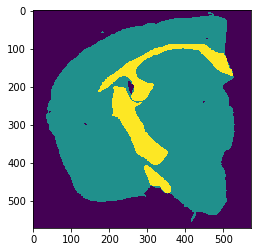

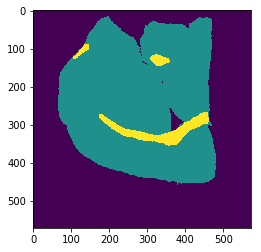

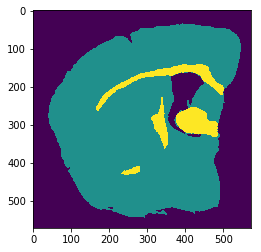

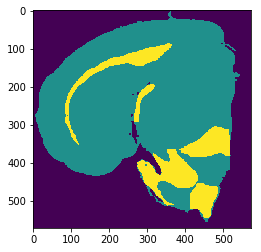

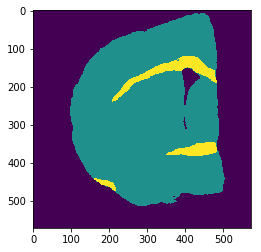

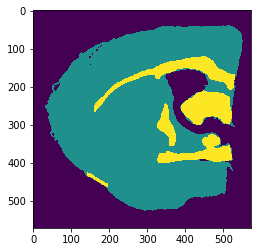

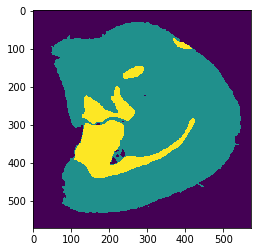

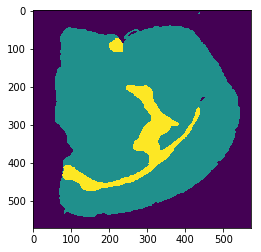

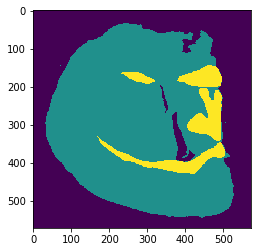

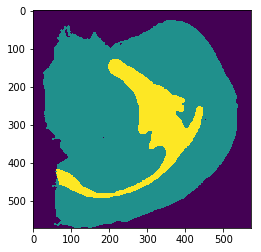

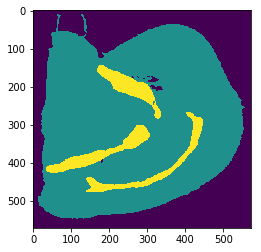

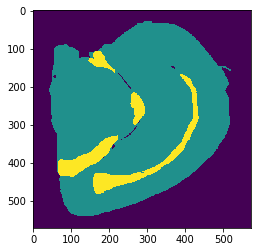

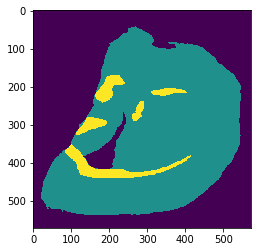

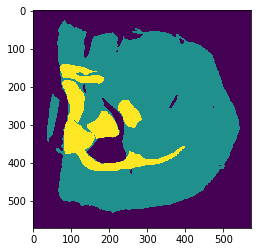

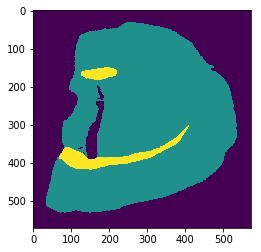

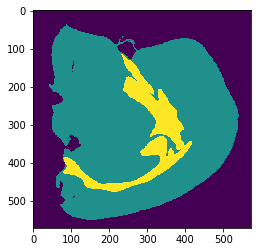

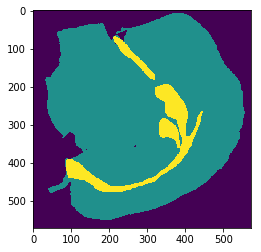

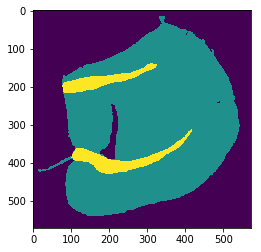

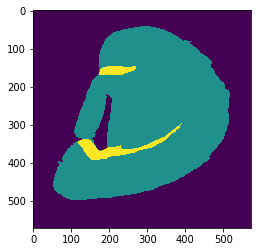

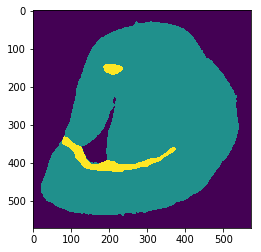

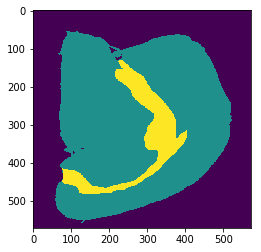

In [9]:
num_train = 24
img_size = 572

tr_lbls_3c = torch.zeros((num_train,img_size,img_size), dtype = torch.long).cuda()
train_dir = "train_data_preprocessed/"

for i in tqdm(range(num_train)):
    label_addr = train_dir + "label"+ str(i)+".mat"    
    mat_contents = sio.loadmat(label_addr)
    label =mat_contents['label']
    
    tr_lbls_3c[i] = torch.from_numpy(label.astype(int))
    plt.figure(i)
    plt.imshow(tr_lbls_3c[i].cpu())
    
torch.save(tr_lbls_3c,'outputs/training_labels_3class')
#these can now be loaded from file for later parts


# Test Data

In [10]:
num_test = 5
img_size = 572

test_vectors = torch.zeros((num_test,img_size,img_size)).cuda()
test_dir = "test_data_preprocessed/"

for i in tqdm(range(num_test)):
    img_addr = test_dir + "img"+ str(i+25)+".tif"    
    test_vectors[i] = load_image(img_addr)
    
torch.save(test_vectors,'outputs/test_vectors')
#these can now be loaded from file for later parts

In [11]:
num_test = 5
img_size = 572

test_vectors_rgb = torch.zeros((num_test,3,img_size,img_size)).cuda()
test_dir = "test_data_preprocessed/"

for i in tqdm(range(num_test)):
    img_addr = test_dir + "img_rgb"+ str(i+25)+".tif"    
    test_vectors_rgb[i] = load_image(img_addr)
    
torch.save(test_vectors_rgb,'outputs/test_vectors_rgb')
#these can now be loaded from file for later parts

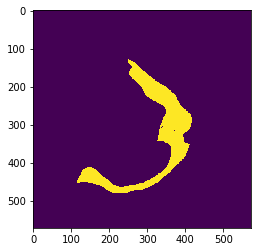

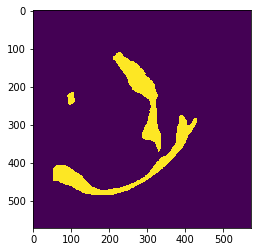

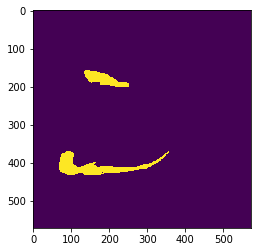

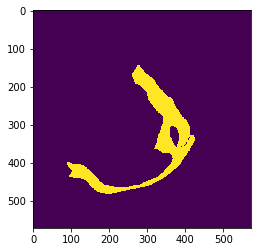

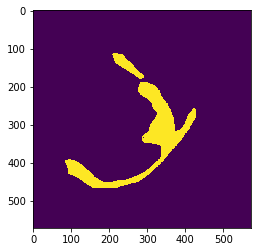

In [12]:
num_test = 5
img_size = 572

test_lbls_2c = torch.zeros((num_test,img_size,img_size), dtype = torch.long).cuda()
test_dir = "test_data_preprocessed/"

for i in tqdm(range(num_test)):
    label_addr = test_dir + "label"+ str(i+25)+".mat"    
    mat_contents = sio.loadmat(label_addr)
    label =mat_contents['label']
    
    ind = np.where(label==2)
    new_label = np.zeros_like(label)
    new_label[ind] = 1
    
    test_lbls_2c[i] = torch.from_numpy(new_label.astype(int))
    plt.figure(i)
    plt.imshow(test_lbls_2c[i].cpu())

torch.save(test_lbls_2c,'outputs/test_labels_2class')
#these can now be loaded from file for later parts


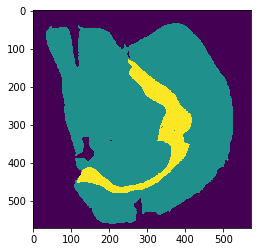

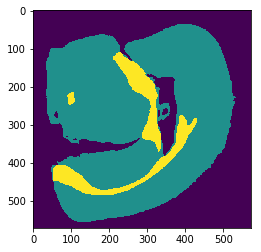

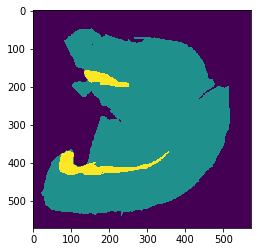

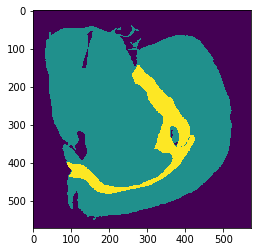

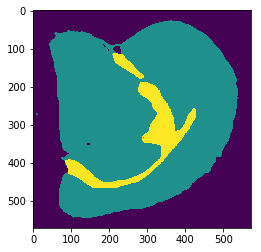

In [13]:
num_test = 5
img_size = 572

test_lbls_3c = torch.zeros((num_train,img_size,img_size), dtype = torch.long).cuda()
test_dir = "test_data_preprocessed/"

for i in tqdm(range(num_test)):
    label_addr = test_dir + "label"+ str(i+25)+".mat"    
    mat_contents = sio.loadmat(label_addr)
    label =mat_contents['label']
    
    test_lbls_3c[i] = torch.from_numpy(label.astype(int))
    plt.figure(i)
    plt.imshow(test_lbls_3c[i].cpu())
    
torch.save(test_lbls_3c,'outputs/test_labels_3class')
#these can now be loaded from file for later parts

# Determining Class Distributions

Since white matter tracts are a lot smaller than the glass and grey matter sections, we need to find the distribution so the loss can be weighted appropriately.

In [14]:
tot_wm = 0
tot_gm = 0

for i in range(24):
    arr = tr_lbls_3c[i].squeeze().cpu().numpy()
    tot_wm += sum(arr[arr==2])/2
    tot_gm += sum(arr[arr==1])

print("White matter pixels percentage: %.f" % (tot_wm/24/(572**2)*100))
print("Grey matter pixels percentage: %.f" % (tot_gm/24/(572**2)*100))
print("Glass pixels percentage: %.f" % (100-tot_gm/24/(572**2)*100-tot_wm/24/(572**2)*100))


White matter pixels percentage: 6
Grey matter pixels percentage: 49
Glass pixels percentage: 45


# Experiment 1: Grayscale Images and Binary Classes

In [75]:
device = torch.device('cuda')#'cuda' if torch.cuda.is_available() else 'cpu')

# imbalanced classes
weights = [0.05, 0.95]
class_weights = torch.tensor(weights).to(device)

training_vectors = torch.load('outputs/training_vectors')
tr_lbls_2c = torch.load('outputs/training_labels_2class')

model1 = UNet(n_classes=2, padding=True, up_mode='upconv').to(device)
optim = torch.optim.Adam(model1.parameters(),lr = 0.00001)
criterion = nn.CrossEntropyLoss(weight = class_weights)

epochs = 40
num_train = 24

for e in range(epochs):
    
    epoch_loss = 0
    for i in range(num_train):

        prediction = model1(training_vectors[i].view(1,1,572,572))
        loss = criterion(prediction, tr_lbls_2c[i,6:566,6:566].unsqueeze(0))
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_loss += loss
        
    # Data Augmentation
    
    for i in range(num_train):

        prediction = model1(training_vectors[i].transpose(0,1).view(1,1,572,572))
        loss = criterion(prediction, tr_lbls_2c[i,6:566,6:566].transpose(0,1).unsqueeze(0))
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_loss += loss

    

    print("Epoch %2d Loss: %0.4f"%(e, epoch_loss/(num_train*2)))

Epoch  0 Loss: 0.6993
Epoch  1 Loss: 0.6984
Epoch  2 Loss: 0.6975
Epoch  3 Loss: 0.6966
Epoch  4 Loss: 0.6955
Epoch  5 Loss: 0.6938
Epoch  6 Loss: 0.6897
Epoch  7 Loss: 0.6674
Epoch  8 Loss: 0.5395
Epoch  9 Loss: 0.4418
Epoch 10 Loss: 0.3971
Epoch 11 Loss: 0.3655
Epoch 12 Loss: 0.3525
Epoch 13 Loss: 0.3368
Epoch 14 Loss: 0.3137
Epoch 15 Loss: 0.2912
Epoch 16 Loss: 0.2695
Epoch 17 Loss: 0.2538
Epoch 18 Loss: 0.2413
Epoch 19 Loss: 0.2325
Epoch 20 Loss: 0.2247
Epoch 21 Loss: 0.2177
Epoch 22 Loss: 0.2120
Epoch 23 Loss: 0.2077
Epoch 24 Loss: 0.2035
Epoch 25 Loss: 0.1988
Epoch 26 Loss: 0.1941
Epoch 27 Loss: 0.1898
Epoch 28 Loss: 0.1852
Epoch 29 Loss: 0.1806
Epoch 30 Loss: 0.1764
Epoch 31 Loss: 0.1724
Epoch 32 Loss: 0.1687
Epoch 33 Loss: 0.1675
Epoch 34 Loss: 0.1674
Epoch 35 Loss: 0.1710
Epoch 36 Loss: 0.1697
Epoch 37 Loss: 0.1614
Epoch 38 Loss: 0.1540
Epoch 39 Loss: 0.1516


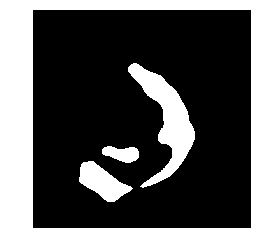

In [119]:
# code adapted from https://github.com/choosehappy/PytorchDigitalPathology/
#prediction = model1(training_vectors[0].view(1,1,572,572))
prediction = model1(test_vectors[0].view(1,1,572,572))

label = prediction.detach().squeeze().cpu().numpy()

label = np.argmax(label,axis=0)
plt.imshow(label,cmap='gray')
plt.axis('off')
plt.savefig('outputs/GB.jpg')
plt.show()


# Experiment 2: Grayscale Images and Three Classes

In [81]:
device = torch.device('cuda')#'cuda' if torch.cuda.is_available() else 'cpu')

# imbalanced classes
weights = [0.05, 0.05, 0.5]
class_weights = torch.tensor(weights).to(device)

training_vectors = torch.load('outputs/training_vectors')
tr_lbls_3c = torch.load('outputs/training_labels_3class')

model2 = UNet(n_classes=3, padding=True, up_mode='upconv').to(device)
optim = torch.optim.Adam(model2.parameters(),lr = 0.00001)
criterion = nn.CrossEntropyLoss(weight = class_weights)

epochs = 40
num_train = 24

for e in range(epochs):
    
    epoch_loss = 0
    for i in range(num_train):

        prediction = model2(training_vectors[i].view(1,1,572,572))
        loss = criterion(prediction, tr_lbls_3c[i,6:566,6:566].unsqueeze(0))
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_loss += loss
        
    # Data Augmentation
    
    for i in range(num_train):

        prediction = model2(training_vectors[i].transpose(0,1).view(1,1,572,572))
        loss = criterion(prediction, tr_lbls_3c[i,6:566,6:566].transpose(0,1).unsqueeze(0))
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_loss += loss

    

    print("Epoch %2d Loss: %0.4f"%(e, epoch_loss/(num_train*2)))

Epoch  0 Loss: 1.0913
Epoch  1 Loss: 1.0882
Epoch  2 Loss: 1.0838
Epoch  3 Loss: 1.0737
Epoch  4 Loss: 1.0020
Epoch  5 Loss: 0.7837
Epoch  6 Loss: 0.5702
Epoch  7 Loss: 0.5001
Epoch  8 Loss: 0.4514
Epoch  9 Loss: 0.4394
Epoch 10 Loss: 0.4225
Epoch 11 Loss: 0.4114
Epoch 12 Loss: 0.4016
Epoch 13 Loss: 0.3934
Epoch 14 Loss: 0.3864
Epoch 15 Loss: 0.3804
Epoch 16 Loss: 0.3746
Epoch 17 Loss: 0.3689
Epoch 18 Loss: 0.3635
Epoch 19 Loss: 0.3577
Epoch 20 Loss: 0.3520
Epoch 21 Loss: 0.3459
Epoch 22 Loss: 0.3393
Epoch 23 Loss: 0.3323
Epoch 24 Loss: 0.3247
Epoch 25 Loss: 0.3162
Epoch 26 Loss: 0.3078
Epoch 27 Loss: 0.2981
Epoch 28 Loss: 0.2881
Epoch 29 Loss: 0.2783
Epoch 30 Loss: 0.2689
Epoch 31 Loss: 0.2583
Epoch 32 Loss: 0.2488
Epoch 33 Loss: 0.2396
Epoch 34 Loss: 0.2328
Epoch 35 Loss: 0.2247
Epoch 36 Loss: 0.2192
Epoch 37 Loss: 0.2145
Epoch 38 Loss: 0.2134
Epoch 39 Loss: 0.2093


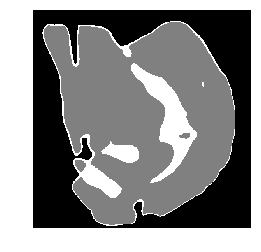

In [120]:
# code adapted from https://github.com/choosehappy/PytorchDigitalPathology/

prediction = model2(test_vectors[0].view(1,1,572,572))

label = prediction.detach().squeeze().cpu().numpy()

label = np.argmax(label,axis=0)
plt.imshow(label,cmap='gray')
plt.axis('off')
plt.savefig('outputs/GT.jpg')
plt.show()


# Experiment 3: RGB Images and Binary Classes

In [85]:
device = torch.device('cuda')#'cuda' if torch.cuda.is_available() else 'cpu')

# imbalanced classes
weights = [0.05, 0.95]
class_weights = torch.tensor(weights).to(device)

training_vectors_rgb = torch.load('outputs/training_vectors_rgb')
tr_lbls_2c = torch.load('outputs/training_labels_2class')

model3 = UNet(in_channels=3, n_classes=2, padding=True, up_mode='upconv').to(device)
optim = torch.optim.Adam(model3.parameters(),lr = 0.00001)
criterion = nn.CrossEntropyLoss(weight = class_weights)

epochs = 40
num_train = 24

for e in range(epochs):
    
    epoch_loss = 0
    for i in range(num_train):

        prediction = model3(training_vectors_rgb[i].view(1,3,572,572))
        loss = criterion(prediction, tr_lbls_2c[i,6:566,6:566].unsqueeze(0))
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_loss += loss
        
    # Data Augmentation
    
    for i in range(num_train):

        prediction = model3(training_vectors_rgb[i].transpose(1,2).view(1,3,572,572))
        loss = criterion(prediction, tr_lbls_2c[i,6:566,6:566].transpose(0,1).unsqueeze(0))
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_loss += loss

    

    print("Epoch %2d Loss: %0.4f"%(e, epoch_loss/(num_train*2)))

Epoch  0 Loss: 0.6933
Epoch  1 Loss: 0.6928
Epoch  2 Loss: 0.6923
Epoch  3 Loss: 0.6915
Epoch  4 Loss: 0.6904
Epoch  5 Loss: 0.6881
Epoch  6 Loss: 0.6780
Epoch  7 Loss: 0.6251
Epoch  8 Loss: 0.5087
Epoch  9 Loss: 0.4477
Epoch 10 Loss: 0.4136
Epoch 11 Loss: 0.4031
Epoch 12 Loss: 0.3939
Epoch 13 Loss: 0.3689
Epoch 14 Loss: 0.3616
Epoch 15 Loss: 0.3301
Epoch 16 Loss: 0.3019
Epoch 17 Loss: 0.2755
Epoch 18 Loss: 0.2674
Epoch 19 Loss: 0.2712
Epoch 20 Loss: 0.2596
Epoch 21 Loss: 0.2532
Epoch 22 Loss: 0.2470
Epoch 23 Loss: 0.2410
Epoch 24 Loss: 0.2371
Epoch 25 Loss: 0.2336
Epoch 26 Loss: 0.2299
Epoch 27 Loss: 0.2275
Epoch 28 Loss: 0.2252
Epoch 29 Loss: 0.2244
Epoch 30 Loss: 0.2252
Epoch 31 Loss: 0.2227
Epoch 32 Loss: 0.2149
Epoch 33 Loss: 0.2097
Epoch 34 Loss: 0.2065
Epoch 35 Loss: 0.2032
Epoch 36 Loss: 0.2006
Epoch 37 Loss: 0.1993
Epoch 38 Loss: 0.1986
Epoch 39 Loss: 0.1975


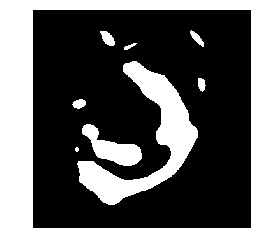

In [121]:
# code adapted from https://github.com/choosehappy/PytorchDigitalPathology/

prediction = model3(test_vectors_rgb[0].view(1,3,572,572))

label = prediction.detach().squeeze().cpu().numpy()

label = np.argmax(label,axis=0)
plt.imshow(label,cmap='gray')
plt.axis('off')
plt.savefig('outputs/RB.jpg')
plt.show()


# Experiment 4: RGB Images and Three Classes

In [90]:
device = torch.device('cuda')#'cuda' if torch.cuda.is_available() else 'cpu')

# imbalanced classes
weights = [0.05, 0.05, 0.5]
class_weights = torch.tensor(weights).to(device)

training_vectors_rgb = torch.load('outputs/training_vectors_rgb')
tr_lbls_3c = torch.load('outputs/training_labels_3class')

model4 = UNet(in_channels=3, n_classes=3, padding=True, up_mode='upconv').to(device)
optim = torch.optim.Adam(model4.parameters(),lr = 0.00001)
criterion = nn.CrossEntropyLoss(weight = class_weights)
#criterion = nn.CrossEntropyLoss()

epochs = 40
num_train = 24

for e in range(epochs):
    
    epoch_loss = 0
    for i in range(num_train):

        prediction = model4(training_vectors_rgb[i].view(1,3,572,572))
        loss = criterion(prediction, tr_lbls_3c[i,6:566,6:566].unsqueeze(0))
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_loss += loss
    
    # Data Augmentation
    
    for i in range(num_train):

        prediction = model4(training_vectors_rgb[i].transpose(1,2).view(1,3,572,572))
        loss = criterion(prediction, tr_lbls_3c[i,6:566,6:566].transpose(0,1).unsqueeze(0))
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_loss += loss

    

    print("Epoch %2d Loss: %0.4f"%(e, epoch_loss/(num_train*2)))

Epoch  0 Loss: 1.1003
Epoch  1 Loss: 1.0977
Epoch  2 Loss: 1.0926
Epoch  3 Loss: 1.0814
Epoch  4 Loss: 0.9709
Epoch  5 Loss: 0.7064
Epoch  6 Loss: 0.5494
Epoch  7 Loss: 0.5086
Epoch  8 Loss: 0.4898
Epoch  9 Loss: 0.4731
Epoch 10 Loss: 0.4566
Epoch 11 Loss: 0.4397
Epoch 12 Loss: 0.4313
Epoch 13 Loss: 0.4214
Epoch 14 Loss: 0.4140
Epoch 15 Loss: 0.4076
Epoch 16 Loss: 0.4019
Epoch 17 Loss: 0.3966
Epoch 18 Loss: 0.3902
Epoch 19 Loss: 0.3832
Epoch 20 Loss: 0.3755
Epoch 21 Loss: 0.3673
Epoch 22 Loss: 0.3598
Epoch 23 Loss: 0.3500
Epoch 24 Loss: 0.3395
Epoch 25 Loss: 0.3270
Epoch 26 Loss: 0.3119
Epoch 27 Loss: 0.2982
Epoch 28 Loss: 0.2869
Epoch 29 Loss: 0.2767
Epoch 30 Loss: 0.2603
Epoch 31 Loss: 0.2547
Epoch 32 Loss: 0.2458
Epoch 33 Loss: 0.2375
Epoch 34 Loss: 0.2341
Epoch 35 Loss: 0.2317
Epoch 36 Loss: 0.2247
Epoch 37 Loss: 0.2187
Epoch 38 Loss: 0.2139
Epoch 39 Loss: 0.2099


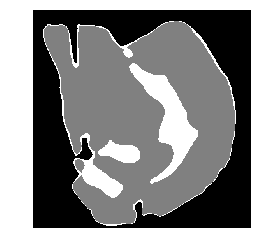

In [122]:
# code adapted from https://github.com/choosehappy/PytorchDigitalPathology/

prediction = model4(test_vectors_rgb[0].view(1,3,572,572))

label = prediction.detach().squeeze().cpu().numpy()

label = np.argmax(label,axis=0)
plt.imshow(label,cmap='gray')
plt.axis('off')
plt.savefig('outputs/RT.jpg')
plt.show()


In [111]:
def eval_model(model, isRgb, num_classes):
    
    total = 560**2
    
    if num_classes == 2:
        cm = np.zeros((2,2))
        for i in range(5):
            y_true = test_lbls_2c[i,6:566,6:566].detach().squeeze().cpu().numpy()
            if isRgb == False:
                y_pred = model(test_vectors[i].view(1,1,572,572))
                y_pred = y_pred.detach().squeeze().cpu().numpy()
                y_pred = np.argmax(y_pred,axis=0)
            
            else:
                y_pred = model(test_vectors_rgb[i].view(1,3,572,572))
                y_pred = y_pred.detach().squeeze().cpu().numpy()
                y_pred = np.argmax(y_pred,axis=0)
            
            cm += confusion_matrix(y_true.flatten(), y_pred.flatten())
        
        cm = cm / 5
        
        acc   = (cm[0,0]+cm[1,1])/total
        prec  = cm[1,1]/(cm[0,1]+cm[1,1])
        prev  = (cm[1,0]+cm[1,1])/total
        TPR   = cm[1,1]/(cm[1,0]+cm[1,1])


    else:
        
        cm = np.zeros((3,3))
        for i in range(5):
            y_true = test_lbls_3c[i,6:566,6:566].detach().squeeze().cpu().numpy()
            if isRgb == False:
                y_pred = model(test_vectors[i].view(1,1,572,572))
                y_pred = y_pred.detach().squeeze().cpu().numpy()
                y_pred = np.argmax(y_pred,axis=0)
            
            else:
                y_pred = model(test_vectors_rgb[i].view(1,3,572,572))
                y_pred = y_pred.detach().squeeze().cpu().numpy()
                y_pred = np.argmax(y_pred,axis=0)

            cm += confusion_matrix(y_true.flatten(), y_pred.flatten())
        
        cm = cm / 5
        
        acc   = (cm[0,0]+cm[1,1]+cm[2,2])/total
        prec  = cm[2,2]/(cm[0,2]+cm[1,2]+cm[2,2])
        prev  = (cm[2,0]+cm[2,1]+cm[2,2])/total
        TPR   = cm[2,2]/((cm[2,0]+cm[2,1]+cm[2,2]))
        
    print("segmentation accuracy is %0.1f" % (acc*100) )
    print("white matter precision is %0.1f" % (prec*100))
    print("white matter prevalence is %0.1f" % (prev*100) )
    print("white matter true positive rate is %0.1f\n" % (TPR*100) )


In [112]:
eval_model(model1, isRgb=0, num_classes=2)
eval_model(model2, isRgb=0, num_classes=3)
eval_model(model3, isRgb=1, num_classes=2)
eval_model(model4, isRgb=1, num_classes=3)

segmentation accuracy is 94.9
white matter precision is 53.6
white matter prevalence is 5.8
white matter true positive rate is 84.1

segmentation accuracy is 92.8
white matter precision is 43.5
white matter prevalence is 5.8
white matter true positive rate is 73.1

segmentation accuracy is 87.8
white matter precision is 31.3
white matter prevalence is 5.8
white matter true positive rate is 92.6

segmentation accuracy is 92.3
white matter precision is 41.4
white matter prevalence is 5.8
white matter true positive rate is 74.2



# Data Augmentation

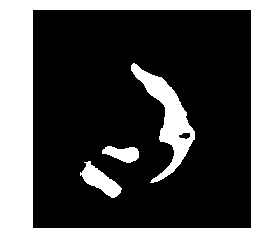

In [135]:
i = 0
y_true = test_lbls_2c[i,6:566,6:566].detach().squeeze().cpu().numpy()

y_pred = model1(test_vectors[i].view(1,1,572,572))
y_pred = y_pred.detach().squeeze().cpu().numpy()
y_pred1 = np.argmax(y_pred,axis=0) #1

y_pred = model2(test_vectors[i].view(1,1,572,572))
y_pred = y_pred.detach().squeeze().cpu().numpy()
y_pred2 = np.argmax(y_pred,axis=0) #2

y_pred = model3(test_vectors_rgb[i].view(1,3,572,572))
y_pred = y_pred.detach().squeeze().cpu().numpy()
y_pred3 = np.argmax(y_pred,axis=0) #3

y_pred = model4(test_vectors_rgb[i].view(1,3,572,572))
y_pred = y_pred.detach().squeeze().cpu().numpy()
y_pred4 = np.argmax(y_pred,axis=0) #4

y_hat = (y_pred1 + y_pred2 + y_pred3 + y_pred4)//6

plt.imshow(y_hat,cmap='gray')
plt.axis('off')
plt.savefig('outputs/EB.jpg')
plt.show()



In [136]:
cm = confusion_matrix(y_true.flatten(), y_hat.flatten())
print(cm)
print((cm[0,0]+cm[1,1])/572**2*100)
print(cm[1,1]/(cm[0,1]+cm[1,1])*100)
print(cm[1,1]/(cm[1,0]+cm[1,1])*100)

[[286901   5829]
 [  4165  16705]]
92.79365739155949
74.13242211768882
80.04312410158121


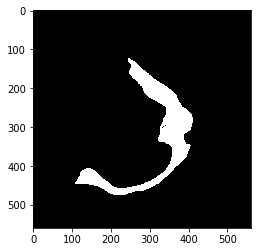

In [110]:
plt.imshow(y_true,cmap='gray')
plt.show()


In [137]:
torch.save(model1, 'outputs/model1.pth')
torch.save(model2, 'outputs/model2.pth')
torch.save(model3, 'outputs/model3.pth')
torch.save(model4, 'outputs/model4.pth')

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type UNetConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type UNetUpBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


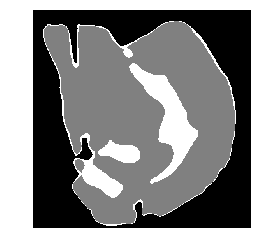

In [142]:
test = torch.load('outputs/model4.pth')

y_pred = test(test_vectors_rgb[i].view(1,3,572,572))
y_pred = y_pred.detach().squeeze().cpu().numpy()
y_hat = np.argmax(y_pred,axis=0) #1
plt.imshow(y_hat,cmap='gray')
plt.axis('off')
plt.savefig('outputs/EB.jpg')
plt.show()